# L2b: What does the largest eigenpair represent?
In this lab, we'll explore PageRank, an algorithm that ranks web pages by importance. While a naive approach might simply count incoming links, we'll discover why this fails and how PageRank uses Markov chains and eigenvector computation to address these limitations.

> __What is PageRank?__
>
> The [PageRank algorithm, developed by Larry Page and Sergey Brin](http://ilpubs.stanford.edu:8090/422/), is used by Google Search to rank web pages in their search engine results. It infers importance purely from link structure: incoming links are votes weighted by the importance of the linking page and diluted by its number of outgoing links. At its core, PageRank models web browsing as a Markov chain, where each webpage represents a state and hyperlinks define transition probabilities. 

In this lab, we'll represent a small network of webpages as a directed graph, examine why naive in-degree counting is insufficient, construct the corresponding transition matrix (a stochastic matrix), and use the power iteration method to compute the stationary distribution (scaled dominant eigenvector) of this Markov chain, which we call PageRank scores.

> __Learning Objectives:__
>
> By the end of this lab, you will be able to:
>
> * __Understand why naive ranking fails:__ Recognize the limitations of in-degree counting and why source quality and link distribution matter.
> * __Build and interpret transition matrices:__ Construct normalized stochastic matrices from adjacency matrices that properly encode importance transfer weighted by source authority.
> * __Apply power iteration to find PageRank:__ Compute the stationary distribution of a Markov chain using power iteration and contrast it with naive in-degree ranking to understand how iterative refinement captures network-based importance.


Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
Next, let's load up the dataset that we will explore. This dataset was generated with the help of generative AI and a simple randomized graph generator for teaching and demonstration purposes. 

It does not contain real hyperlinks, real traffic patterns, or data collected from any website. Any resemblance to real domains is coincidental (the domain-like labels are fabricated).

We've provided [the `MySyntheticPageRankDataset()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MySyntheticPageRankDataset) to load the synthetic PageRank dataset. This function takes no arguments and returns a tuple containing the edges and nodes of the synthetic web graph.

> __What's in the dataset?__
> 
> The dataset contains two data structures: `edges::Dict{Int, Tuple{String, String}}` maps edge indices to pairs of node identifiers (from_node, to_node), representing directed hyperlinks between webpages. The `nodes::Dict{String, NamedTuple}` maps node identifiers to named tuples containing metadata such as page labels, community assignments, and page types.

Let's load the dataset:

In [2]:
(edges, nodes) = MySyntheticPageRankDataset(); # load the synthetic PageRank dataset

#### Exploring the hyperlink structure

Let's start by examining the edge list, the hyperlinks in our synthetic web graph. Each edge represents a directed link from one webpage to another. To understand our ranking problem, we need to ask: **How interconnected is this network? Which pages are linked to most frequently? And most importantly, is simply counting incoming links sufficient to rank importance?**

Let's look at a sample of the edges:


In [3]:
edges

Dict{Int64, Tuple{String, String}} with 2564 entries:
  1144 => ("p0096", "p0104")
  2108 => ("p0188", "p0170")
  1175 => ("p0096", "p0219")
  1953 => ("p0172", "p0142")
  719  => ("p0065", "p0087")
  1546 => ("p0129", "p0126")
  1703 => ("p0143", "p0157")
  1956 => ("p0172", "p0147")
  2261 => ("p0197", "p0201")
  2288 => ("p0200", "p0197")
  1028 => ("p0089", "p0118")
  699  => ("p0063", "p0073")
  831  => ("p0075", "p0045")
  1299 => ("p0108", "p0105")
  1438 => ("p0119", "p0092")
  1074 => ("p0093", "p0110")
  2350 => ("p0205", "p0209")
  2493 => ("p0221", "p0224")
  319  => ("p0023", "p0000")
  ⋮    => ⋮

How about the `nodes::Dict{String, NamedTuple}` dictionary?

In [4]:
nodes

Dict{String, NamedTuple} with 242 entries:
  "p0020" => (nodeid = "p0020", label = "ledger-ne20.com", community = "news", …
  "p0065" => (nodeid = "p0065", label = "review-sc20.net", community = "science…
  "p0229" => (nodeid = "p0229", label = "deal-09-clickbait.com", community = "s…
  "p0217" => (nodeid = "p0217", label = "pop-en42.io", community = "entertainme…
  "p0126" => (nodeid = "p0126", label = "sportsbook-sp36.io", community = "spor…
  "p0070" => (nodeid = "p0070", label = "journal-sc25.com", community = "scienc…
  "p0194" => (nodeid = "p0194", label = "reel-en19.io", community = "entertainm…
  "p0123" => (nodeid = "p0123", label = "locker-sp33.net", community = "sports"…
  "p0156" => (nodeid = "p0156", label = "fund-fi26.io", community = "finance", …
  "p0068" => (nodeid = "p0068", label = "lab-sc23.org", community = "science", …
  "p0200" => (nodeid = "p0200", label = "reel-en25.org", community = "entertain…
  "p0022" => (nodeid = "p0022", label = "bulletin-ne22.net", commu

#### Network statistics and properties

Each node in the `nodes` dictionary carries metadata about the page: a human-readable `label`, a `community` assignment (which pages belong to topically related groups), and a `type` classification. These properties help us understand the network's structure.

Now let's compute some basic graph statistics to characterize our network before applying PageRank:

> __Why compute network statistics?__
>
> Understanding the network's key properties informs our interpretation of PageRank scores. Key metrics include:
> * __Network size and density:__ How many pages are there, and how densely are they linked? Sparse networks may produce PageRank scores with larger variance.
> * __In-degree distribution:__ How many incoming links does each page receive? If in-degree is highly skewed (many pages with few links, few pages with many links), naive in-degree ranking may be dominated by outliers.
> * __Out-degree distribution:__ How many pages does each page link to? This affects the transition matrix: pages with many outgoing links distribute their importance across many neighbors.
> * __Disconnected components:__ Are all pages reachable from each other, or are there isolated subgraphs? This affects Markov chain properties and convergence.
> * __Community structure:__ Do pages cluster into topically related groups? PageRank should respect this structure if links reflect topical relevance.

Let's compute these statistics:


In [5]:
graph_stats = let

    # initialize 
    number_of_edges = length(edges);
    in_degree_dict = Dict{String, Int}();
    out_degree_dict = Dict{String, Int}();
    community_dict = Dict{String, String}();
    
    # iterate over edges to build degree distributions
    for (idx, (from_node, to_node)) ∈ edges
        # count out-degree for from_node
        if haskey(out_degree_dict, from_node)
            out_degree_dict[from_node] += 1;
        else
            out_degree_dict[from_node] = 1;
        end
        
        # count in-degree for to_node
        if haskey(in_degree_dict, to_node)
            in_degree_dict[to_node] += 1;
        else
            in_degree_dict[to_node] = 1;
        end
    end
    
    # extract community and handle missing degrees
    for (node_id, node_data) ∈ nodes
        community_dict[node_id] = node_data.community;
        
        # ensure every node has a degree count (isolated nodes have degree 0)
        if !haskey(in_degree_dict, node_id)
            in_degree_dict[node_id] = 0;
        end
        if !haskey(out_degree_dict, node_id)
            out_degree_dict[node_id] = 0;
        end
    end
    
    (number_of_nodes = length(nodes), 
     number_of_edges = number_of_edges, 
     in_degree_dict = in_degree_dict, 
     out_degree_dict = out_degree_dict,
     community_dict = community_dict)
end;

println("Network size: $(graph_stats.number_of_nodes) pages");
println("Number of hyperlinks: $(graph_stats.number_of_edges) edges");
println("Network density: $(round(graph_stats.number_of_edges / (graph_stats.number_of_nodes * (graph_stats.number_of_nodes - 1)); digits=4))");

Network size: 242 pages
Number of hyperlinks: 2564 edges
Network density: 0.044


#### In-degree distribution: A preview of the ranking problem

Let's examine the in-degree distribution, how many incoming links does each page receive? This will reveal why a naive approach (ranking pages by in-degree alone) is insufficient.

> __The naive approach:__ One might initially assume that the "most important" pages are simply those with the most incoming links (highest in-degree). This is intuitive: if many pages link to you, you must be important. However, this approach has a critical flaw: **it treats all votes equally**, regardless of the importance of the voter. A link from an authority is more valuable than a link from a page that links to everything.

Let's compute in-degree statistics and visualize the distribution:


In-degree statistics:
  Min: 1, Max: 63, Mean: 10.6

Out-degree statistics:
  Min: 0, Max: 67, Mean: 10.6


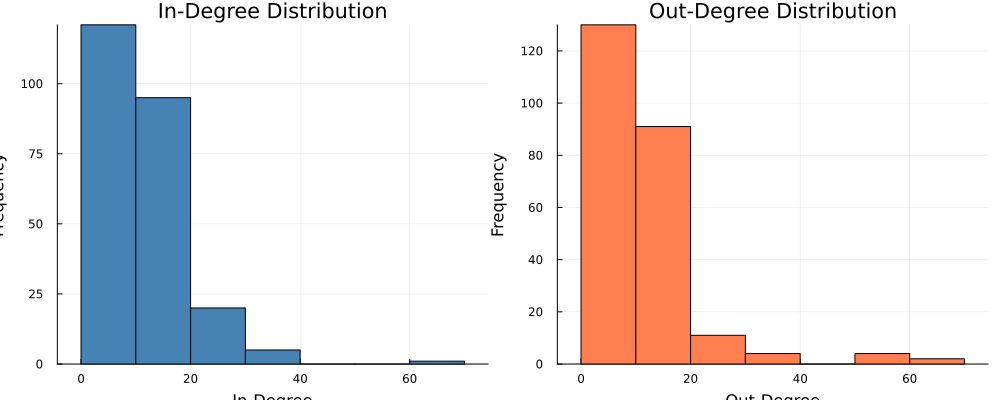

In [6]:
in_degree_values = collect(values(graph_stats.in_degree_dict));
out_degree_values = collect(values(graph_stats.out_degree_dict));

println("In-degree statistics:");
println("  Min: $(minimum(in_degree_values)), Max: $(maximum(in_degree_values)), Mean: $(round(mean(in_degree_values); digits=2))");
println("\nOut-degree statistics:");
println("  Min: $(minimum(out_degree_values)), Max: $(maximum(out_degree_values)), Mean: $(round(mean(out_degree_values); digits=2))");

# plot in-degree and out-degree distributions
let
    fig = plot(layout=(1,2), size=(1000, 400));
    histogram!(fig[1], in_degree_values, bins=10, c=:steelblue, legend=false, title="In-Degree Distribution", xlabel="In-Degree", ylabel="Frequency");
    histogram!(fig[2], out_degree_values, bins=10, c=:coral, legend=false, title="Out-Degree Distribution", xlabel="Out-Degree", ylabel="Frequency");
    
    fig
end

Finally, let's compute a few things we'll need below, in particular the list of nodes and the number of nodes.

In [7]:
number_of_nodes, list_of_nodes = let

    # initialize -
    nodeset = Set{String}();
    number_of_edges = keys(edges) |> length;

    # loop over edges to build the set of nodes. 
    # Trick: Take advantage of the fact that sets do not allow duplicates (nice!)
    for i ∈ 1:number_of_edges
        (from_node, to_node) = edges[i];
        push!(nodeset, from_node);
        push!(nodeset, to_node);
    end

    # Of course, we want a sorted array of nodes (not a set), so let's convert to an array and sort it.
    list_of_nodes = nodeset |> collect |> sort;
    number_of_nodes = length(list_of_nodes); # how many nodes are there?

    (number_of_nodes, list_of_nodes); # return 
end

(242, ["p0000", "p0001", "p0002", "p0003", "p0004", "p0005", "p0006", "p0007", "p0008", "p0009"  …  "p0232", "p0233", "p0234", "p0235", "p0236", "p0237", "p0238", "p0239", "p0240", "p0241"])

### Computing in-degree scores: A baseline for comparison

Let's compute and examine in-degree based "importance" scores. This baseline will reveal exactly where naive counting falls short, and it will make the PageRank approach more intuitive once we implement it.

In [8]:
in_degree_scores = let
    
    # initialize -
    in_degree_scores = zeros(number_of_nodes);
    
    # loop over nodes and get their in-degree
    for i ∈ 1:number_of_nodes
        node_id = list_of_nodes[i];
        in_degree_scores[i] = graph_stats.in_degree_dict[node_id];
    end
    
    # normalize to sum to 1 (like PageRank scores)
    in_degree_scores .= in_degree_scores ./ sum(in_degree_scores);
    
    in_degree_scores
end;

# display the top 10 pages by in-degree
let
    
    i = sortperm(in_degree_scores; rev=true)[1:10]; # indices of top 10
    df = DataFrame();
    
    for j ∈ 1:10
        node_index = i[j];
        node_id = list_of_nodes[node_index];
        page_name = nodes[node_id].label;
        in_degree_score = in_degree_scores[node_index];
        community = nodes[node_id].community;
        type = nodes[node_id].type;
        push!(df, (Rank = j, NodeID = node_id, PageName = page_name, InDegreeScore = in_degree_score, Community = community, Type = type));
    end
    
    # Make a pretty table -
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- -------- -------------------- --------------- ------------------- -------------------
   Rank   NodeID             PageName   InDegreeScore           Community                Type 
  Int64   String    SubString{String}         Float64   SubString{String}   SubString{String} 
 ------- -------- -------------------- --------------- ------------------- -------------------
      1    p0141   promo_cash_now.org        0.024571             finance         spam_target
      2    p0006      gazette-ne06.io       0.0152106                news              portal
      3    p0030    bulletin-ne30.org       0.0132605                news           authority
      4    p0175         pop-en00.net       0.0128705       entertainment           authority
      5    p0185        buzz-en10.net       0.0128705       entertainment           authority
      6    p0079     archive-sc34.net       0.0124805             science           authority
      7    p0104        play-sp14.net       0.0113105   

#### Comparing in-degree to PageRank

Now let's compute PageRank (which we'll do fully in Task 2) and compare the two rankings side by side. This comparison will reveal concrete examples of where naive in-degree fails and why PageRank provides a richer picture of importance.

> __Why the comparison matters:__
>
> By examining pages that rank high in in-degree but low in PageRank (or vice versa), we can understand what each metric captures:
> * **Pages ranking high in both:** These are genuinely important, they're linked to frequently AND by important sources. Consensus rankings build confidence.
> * **Pages high in in-degree but low in PageRank:** These are linked to often, but primarily by unimportant pages. The votes are numerous but from weak sources. This reveals the difference between **popularity** (in-degree) and **authority** (PageRank).
> * **Pages low in in-degree but high in PageRank:** These receive few votes, but those votes come from authoritative pages. A single link from a top authority can confer high PageRank. This reveals how importance is transferred through the network.

We'll compute PageRank next and then visualize these differences.


___

## Task 1: Build the transition matrix

In this task, we'll construct the transition matrix that forms the mathematical foundation of PageRank. We'll build this from the adjacency matrix, then validate its properties.

### Constructing the adjacency matrix

First, let's convert our edge list into an adjacency matrix representation.

> __What is an adjacency matrix?__
>
> An adjacency matrix $\mathbf{A}$ is an $n \times n$ matrix where $n$ is the number of nodes in the graph. Each entry $A_{ij}$ represents the presence or absence of a directed edge from node $i$ to node $j$:
> $$
\begin{align*}
A_{ij} = \begin{cases}
1 & \text{if there is a directed edge from node } i \text{ to node } j \\
0 & \text{otherwise}
\end{cases}
\end{align*}
> $$
> For our web graph, this captures the hyperlink structure: $A_{ij} = 1$ means page $i$ links to page $j$. The adjacency matrix is sparse (contains mostly zeros) for typical web graphs, making sparse matrix representations efficient for computation.

We'll store the adjacency matrix as a sparse matrix to save memory and speed up computations in the `A::SparseMatrixCSC{Int64, Int64}` variable.

In [9]:
A = let

    # initialize -
    A = spzeros(Int, number_of_nodes, number_of_nodes); # sparse adjacency matrix

    # ok, loop over edges to populate the adjacency matrix
    for (i, (from_node, to_node)) ∈ edges
        from_index = findfirst(isequal(from_node), list_of_nodes);
        to_index   = findfirst(isequal(to_node), list_of_nodes);
        A[from_index, to_index] = 1; # unweighted graph
    end
    
    A # return
end;

The sparse adjacency matrix $\mathbf{A}$ is now constructed. Let's examine its structure:

In [10]:
A

242×242 SparseMatrixCSC{Int64, Int64} with 2564 stored entries:
⎡⣵⡿⣿⣿⢸⣿⣽⡆⠠⠠⠄⠀⡀⡄⠀⠈⢠⣅⠄⠠⠠⠠⠄⠆⠀⠀⠀⠀⠀⠄⡄⢄⢄⠀⠤⠠⠆⠀⠀⠀⎤
⎢⣿⣿⡯⡞⣿⡿⣿⡇⠀⠐⠀⢀⢒⠢⣅⠠⠀⠌⠌⠀⠀⢀⠐⡃⠐⠀⠀⠰⠀⡀⠀⠀⠄⠁⠀⠀⠀⠀⠀⠀⎥
⎢⣷⣷⣶⣷⢼⣯⣶⣇⠄⢀⠄⠀⢠⠀⡠⠂⠠⠄⠈⠠⠀⠄⠄⠆⡐⠀⠀⠀⠀⠈⠠⠐⢀⠐⠀⠀⠀⠀⠀⠀⎥
⎢⠟⠿⠿⠾⢤⠿⠿⢃⣂⡀⣀⠄⣀⣀⣀⠐⠀⠀⠐⠀⠀⠄⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠄⠀⠀⡀⠀⎥
⎢⠀⠑⡦⠀⠀⣁⠬⢱⣴⡯⣏⣵⣼⡧⡼⠀⠠⠀⠀⢀⠀⠀⠀⠀⠈⠠⠀⠀⠰⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢘⠀⠡⠀⡁⠀⢸⣽⡯⣕⣫⣿⣯⣺⠀⠀⡀⠀⠀⠀⠀⡀⠠⠀⠀⠀⠀⠐⠀⢀⠀⠀⠀⠀⠂⠀⠀⠀⠀⎥
⎢⠀⢐⠈⠂⠀⠈⠀⢸⣢⣽⣟⣻⢼⡿⣿⠀⠀⠅⠀⠀⠀⠐⠅⠀⠠⠀⠀⠠⠀⠂⠀⠀⠈⠀⠀⠄⠀⠀⠀⠀⎥
⎢⡢⣿⠦⠁⢀⣗⢕⠞⠚⢞⢟⠻⢟⢻⢺⣧⢤⣶⣤⣴⣤⣶⠆⢤⡐⢤⣂⠄⠷⠄⢈⡤⣔⢀⣄⠄⡆⠄⠐⡀⎥
⎢⠀⡐⠤⠔⠠⠡⠰⠀⠀⡀⠤⠁⠀⠄⡂⣿⣻⣿⣧⣿⡽⡓⠠⠃⠀⠄⠀⠀⠂⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⎥
⎢⠐⠄⠖⠐⠄⡃⡀⠀⠀⠆⡀⠀⢠⡄⢂⣿⣿⣿⣯⡾⣿⡇⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠂⠁⠀⠀⡀⠀⠀⠀⎥
⎢⠀⠀⠢⠄⠀⠥⠰⠌⢀⠀⠀⠁⠀⡠⠀⠿⢼⡿⠏⠿⠿⢇⣀⣀⣁⣀⡀⢀⡀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡀⡆⠄⠈⠀⡅⠀⡀⠀⡊⢈⠈⠉⠁⣀⡀⠅⡄⠉⠈⡀⢘⣯⡿⣿⣏⡃⣿⣟⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢈⡐⠀⠀⠂⠀⠁⠀⠔⡀⠀⠀⠂⠣⠂⠀⠀⠂⠀⠀⡀⢸⣿⣷⣿⣮⠏⢏⡢⠀⠁⠀⡀⠀⠂⠀⠀⠀⠀⠀⎥
⎢⠈⠀⠀⡀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠌⠀⡀⠀⠄⠀⢈⠀⢰⣟⣿⠿⣿⡤⠸⣁⠀⠀⢀⠀⠀⠈⠀⠀⠀⠀⠀⎥
⎢⠁⢁⠉⠈⠁⠃⠈⢙⠐⠍⠀⠩⢈⠁⠉⠉⠊⠀⠀⠀⠡⠉⠋⠋⠉⠉⠋⠉⢩⡔⢴⢮⢤⠶⣪⣅⡇⠀⠁⠀⎥
⎢⡅⢨⠀⠌⠤⠀⢄⠤⠄⠠⠤⠨⠀⠬⠀⠥⠀⠤⠤⠄⠀⠴⠤⠤⠁⠄⢄⢠⣼⣯⣾⣭⣾⣧⣿⣭⡇⠁⠀⠀⎥
⎢⠀⡆⠀⠀⢀⠠⠀⢠⠀⠀⠀⠀⠀⠁⠄⠁⠀⠀⠄⠀⠢⠄⠀⠂⠀⠈⠀⠀⢬⡽⣽⢥⣼⠿⣿⡿⡇⠀⠀⠀⎥
⎢⠁⠆⠠⠀⠂⠀⠄⠀⠀⠈⠀⠀⢀⠂⡈⠄⠀⠀⠀⠀⠂⢀⠀⠄⠐⠂⠁⠀⢘⣯⢻⣍⢭⣽⣿⡧⡇⠀⠀⠀⎥
⎢⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠈⠈⠀⠈⠁⠀⠁⠼⣾⠗⡓⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢵⠻⢑⠴⎦

### Computing the transition matrix

From the adjacency matrix, we can compute the transition matrix. 

> __What is a transition matrix?__
> 
> A transition matrix $\mathbf{P}\in\mathbb{R}^{n \times n}$ is a row-stochastic matrix that describes how system can transition between states in a Markov chain. For our web graph application, each entry $P_{ij}$ represents the probability that a random surfer at page $i$ follows a link to page $j$. The entries of the transition matrix are computed as follows:
> $$
\begin{align*}
P_{ij} = \begin{cases}
\frac{A_{ij}}{k} & \text{if page } i \text{ has } k \text{ outgoing links} \\
\frac{1}{n} & \text{if page } i \text{ is a dangling node (no outgoing links)}
\end{cases}
\end{align*}
> $$
> where $k$ is the out-degree of page $i$ (the number of outgoing links from page $i$), and $n$ is the total number of pages (nodes) in the graph. This normalization ensures each row sums to one, making it a valid probability distribution.

Let's compute the transition matrix:

In [11]:
P = let

    # initialize -
    P = spzeros(Float64, number_of_nodes, number_of_nodes); # sparse transition matrix

    # loop over rows of A to compute the transition matrix
    for i ∈ 1:number_of_nodes
        row_sum = sum(A[i, :]); # sum of the i-th row
        if row_sum != 0
            P[i, :] .= A[i, :] ./ row_sum; # normalize the row (fancy! what is .= doing here?)
        else
            P[i, :] .= 1.0 / number_of_nodes; # handle dangling nodes (no outgoing edges)
        end
    end

    P # return
end

242×242 SparseMatrixCSC{Float64, Int64} with 4500 stored entries:
⎡⣵⡿⣿⣿⢸⣿⣽⡆⠠⠠⠄⠀⡀⡄⠀⠈⢠⣅⠄⠠⠠⠠⠄⠆⠀⠀⠀⠀⠀⠄⡄⢄⢄⠀⠤⠠⠆⠀⠀⠀⎤
⎢⣿⣿⡯⡞⣿⡿⣿⡇⠀⠐⠀⢀⢒⠢⣅⠠⠀⠌⠌⠀⠀⢀⠐⡃⠐⠀⠀⠰⠀⡀⠀⠀⠄⠁⠀⠀⠀⠀⠀⠀⎥
⎢⣷⣷⣶⣷⢼⣯⣶⣇⠄⢀⠄⠀⢠⠀⡠⠂⠠⠄⠈⠠⠀⠄⠄⠆⡐⠀⠀⠀⠀⠈⠠⠐⢀⠐⠀⠀⠀⠀⠀⠀⎥
⎢⠟⠿⠿⠾⢤⠿⠿⢃⣂⡀⣀⠄⣀⣀⣀⠐⠀⠀⠐⠀⠀⠄⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠄⠀⠀⡀⠀⎥
⎢⠀⠑⡦⠀⠀⣁⠬⢱⣴⡯⣏⣵⣼⡧⡼⠀⠠⠀⠀⢀⠀⠀⠀⠀⠈⠠⠀⠀⠰⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠉⢙⠉⠩⠉⡉⠉⢹⣽⡯⣝⣫⣿⣯⣻⠉⠉⡉⠉⠉⠉⠉⡉⠩⠉⠉⠉⠉⠙⠉⢉⠉⠉⠉⠉⠋⠉⠉⠉⠉⎥
⎢⠀⢐⠈⠂⠀⠈⠀⢸⣢⣽⣟⣻⢼⡿⣿⠀⠀⠅⠀⠀⠀⠐⠅⠀⠠⠀⠀⠠⠀⠂⠀⠀⠈⠀⠀⠄⠀⠀⠀⠀⎥
⎢⡢⣿⠦⠁⢀⣗⢕⠞⠚⢞⢟⠻⢟⢻⢺⣧⢤⣶⣤⣴⣤⣶⠆⢤⡐⢤⣂⠄⠷⠄⢈⡤⣔⢀⣄⠄⡆⠄⠐⡀⎥
⎢⠉⡙⠭⠝⠩⠩⠹⠉⠉⡉⠭⠉⠉⠍⡋⣿⣻⣿⣯⣿⡽⡛⠩⠋⠉⠍⠉⠉⠋⠉⠉⠉⠉⠉⠩⠉⠉⠉⠉⠉⎥
⎢⠴⠤⠶⠴⠤⡧⡤⠤⠤⠦⡤⠤⢤⡤⢦⣿⣿⣿⣯⡾⣿⡧⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠦⠥⠤⠤⡤⠤⠤⠤⎥
⎢⠀⠀⠢⠄⠀⠥⠰⠌⢀⠀⠀⠁⠀⡠⠀⠿⢼⡿⠏⠿⠿⢇⣀⣀⣁⣀⡀⢀⡀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡀⡆⠄⠈⠀⡅⠀⡀⠀⡊⢈⠈⠉⠁⣀⡀⠅⡄⠉⠈⡀⢘⣯⡿⣿⣏⡃⣿⣟⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣈⣐⣀⣀⣂⣀⣁⣀⣔⣀⣀⣀⣂⣣⣂⣀⣀⣂⣀⣀⣀⣸⣿⣷⣿⣮⣏⣏⣢⣀⣁⣀⣀⣀⣂⣀⣀⣀⣀⣀⎥
⎢⠾⠶⠶⡶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠾⠶⡶⠶⠶⠶⢾⠶⢶⣿⣿⠿⣿⡶⠾⣷⠶⠶⢶⠶⠶⠾⠶⠶⠶⠶⠶⎥
⎢⠁⢁⠉⠈⠁⠃⠈⢙⠐⠍⠀⠩⢈⠁⠉⠉⠊⠀⠀⠀⠡⠉⠋⠋⠉⠉⠋⠉⢩⡔⢴⢮⢤⠶⣪⣅⡇⠀⠁⠀⎥
⎢⡅⢨⠀⠌⠤⠀⢄⠤⠄⠠⠤⠨⠀⠬⠀⠥⠀⠤⠤⠄⠀⠴⠤⠤⠁⠄⢄⢠⣼⣯⣾⣭⣾⣧⣿⣭⡇⠁⠀⠀⎥
⎢⠉⡏⠉⠉⢉⠩⠉⢩⠉⠉⠉⠉⠉⠉⠍⠉⠉⠉⠍⠉⠫⠍⠉⠋⠉⠉⠉⠉⢭⡽⣽⢭⣽⠿⣿⡿⡏⠉⠉⠉⎥
⎢⠓⠖⠲⠒⠒⠒⠖⠒⠒⠚⠒⠒⢒⠒⡚⠖⠒⠒⠒⠒⠒⢒⠒⠖⠒⠒⠓⠒⢚⣿⢻⣟⢿⣿⣿⡷⡗⠒⠒⠒⎥
⎢⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠈⠈⠀⠈⠁⠀⠁⠼⣾⠗⡓⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢵⠻⢑⠴⎦

__Check__: If this is correct, then each row of the transition matrix should sum to one. You can verify this by summing the rows of the transition matrix and checking if they equal one.

In [12]:
let

    # initialize -
    number_of_nodes = size(P, 1);

    for i ∈ 1:number_of_nodes
        row_sum = sum(P[i, :]);
        @assert isapprox(row_sum, 1.0; atol=1e-8) "Row $i does not sum to 1, sum = $row_sum";
    end
end

Let's take a look at a few rows of the transition matrix. 

In [13]:
P[1,:]

242-element SparseVector{Float64, Int64} with 12 stored entries:
  [7 ]  =  0.0833333
  [11]  =  0.0833333
  [13]  =  0.0833333
  [16]  =  0.0833333
  [19]  =  0.0833333
  [20]  =  0.0833333
  [27]  =  0.0833333
  [30]  =  0.0833333
  [31]  =  0.0833333
  [37]  =  0.0833333
  [40]  =  0.0833333
  [96]  =  0.0833333

___

## Task 2: Compute PageRank using power iteration and compare to naive ranking
In this task, we will compute the largest eigenpair of the transition matrix $\mathbf{P}$ using the power iteration method, yielding the PageRank scores. 

We've implemented [the power-iteration method pseudo-code](CHEME-5820-PowerIteration-Algorithm-Spring-2026.ipynb) in the [`Eigendecomposition.jl` file in the `src` directory](src/Eigendecomposition.jl). After computing PageRank, we'll compare the results directly to the in-degree ranking from Task 1, revealing exactly where naive link counting fails and why the iterative, weighted approach of PageRank is superior.

### Computing the stationary distribution

> __Connection to Markov Processes:__
>
> The transition matrix $\mathbf{P}$ defines a discrete-time Markov chain on the web graph, and a central question is whether a stationary distribution exists:
>
> * __Stationary Distribution:__ The stationary distribution $\boldsymbol{\pi}$ is a probability vector that satisfies $\boldsymbol{\pi}^{\top}\mathbf{P} = \boldsymbol{\pi}^{\top}$, meaning it remains unchanged after one step of the random walk. By transposing both sides, we get the eigenvalue equation $\mathbf{P}^{\top}\boldsymbol{\pi} = \boldsymbol{\pi}$, showing that $\boldsymbol{\pi}$ is an eigenvector of $\mathbf{P}^{\top}$ with eigenvalue $\lambda = 1$
>
> For an irreducible, aperiodic chain, the corresponding eigenvector has all positive entries and is unique up to scalar multiplication. Thus, when properly normalized, this eigenvector represents the long-run fraction of time a random surfer spends at each webpage.

The algorithm iterates until the change in the eigenvector estimate (measured by the L1-norm) falls below a tolerance of $\epsilon = 10^{-8}$. 

Let's run the power iteration:

In [14]:
λ̂,v̂ = let

    # initialize -
    max_iterations = 1000;
    tolerance      = 1e-8;
    v = rand(number_of_nodes); # random initial eigenvector
    v .= v ./ norm(v, 1);      # normalize
    A = transpose(P) |> Matrix;  # we want the left eigenvector, so we work with the transpose

    # call the power iteration method
    result = poweriteration(A, v; maxiter = max_iterations, ϵ = tolerance);

    (result.value, result.vector) # return
end

Converged in 31 iterations


(1.0000061924848473, [0.131345453586416, 0.01299203013310009, 0.10260563899267013, 0.011474569226453296, 0.11173835749705249, 0.06255724357160947, 0.2631927662173048, 0.07035171347888529, 0.10734195267560229, 0.03470958837226986  …  0.009950354533163234, 0.0064605195979085235, 0.0020407100669637885, 0.0020829447364923946, 0.0032420373387307497, 0.0017066678921411553, 0.002199566063822593, 0.002760560585713916, 0.002959877393353484, 0.002434450931895877])

What is the largest eigenvalue and corresponding eigenvector of the transition matrix $\mathbf{P}$? Theory tells us that $\hat{λ} = 1$ should be the largest eigenvalue of a transition matrix. Let's see if our computation agrees with this.

In [15]:
@assert isapprox(λ̂, 1.0; atol=1e-4) # adjust atol to find the max permissible error

Next, we need to normalize the eigenvector to obtain the stationary distribution (PageRank scores).

> __Why normalize the eigenvector?__
> 
> The power iteration returns an eigenvector $\hat{\mathbf{v}}$ satisfying $\mathbf{P}^{\top}\hat{\mathbf{v}} = \hat{\mathbf{v}}$, but eigenvectors are only defined up to scalar multiplication: if $\mathbf{v}$ is an eigenvector, then so is $c\mathbf{v}$ for any nonzero scalar $c$. The power iteration algorithm normalizes at each step to prevent numerical overflow, but the final vector is not necessarily a probability distribution. To interpret $\hat{\mathbf{v}}$ as a stationary distribution $\boldsymbol{\pi}$, we require that its entries sum to one: $\sum_{i=1}^{n}\pi_{i} = 1$, where $\pi_{i}$ denotes the $i$-th entry of $\boldsymbol{\pi}$ representing the fraction of time spent at node $i$.
>
> The normalization $\hat{\pi} = \hat{\mathbf{v}}/(\mathbf{1}^{\top}\hat{\mathbf{v}})$, where $\mathbf{1}$ is a vector of ones, ensures this property while preserving the relative magnitudes that encode webpage importance.

Let's compute the stationary distribution which we save in the `π̂::Array{Float64,1}` variable: 

In [16]:
π̂ = let
    
    # initialize -
    ones_vector = ones(number_of_nodes);
    T = dot(ones_vector, v̂); # normalization factor
    π̂  = v̂ ./ T # return
end

242-element Vector{Float64}:
 0.011599915395307768
 0.0011474051536781668
 0.009061727672312517
 0.001013388957059616
 0.009868293557063883
 0.005524810436753325
 0.023244153013405107
 0.006213187453291511
 0.009480020323542386
 0.003065414732908039
 ⋮
 0.00057056775624259
 0.00018022751055907888
 0.00018395751095043832
 0.000286324024249248
 0.00015072621561050445
 0.0001942570492548133
 0.00024380188551280385
 0.00026140476435139757
 0.00021500115971232142

__Check__: The entries of the stationary distribution $\hat{\pi}$ should sum to one. You can verify this by summing the entries of $\hat{\pi}$.

In [17]:
@assert isapprox(sum(π̂), 1.0; atol=1e-8) # check that the entries sum to one

Ok, but what does this stationary distribution represent in the context of our web graph? 

> __PageRank and Stationary Distribution__
> In the context of PageRank, the stationary distribution $\hat{\pi}$ represents the long-term behavior of a random surfer navigating the web graph. Each entry $\hat{\pi}_i$ in the stationary distribution corresponds to the probability of being at node (webpage) $i$ after a large number of steps in a random walk on the graph.

Let's find the most important webpage:

In [18]:
nodeid = let
    i = argmax(π̂);
    nodeid = list_of_nodes[i];
    println("The most important webpage is: $(list_of_nodes[i]) with PageRank score $(π̂[i])");
    nodeid;
end;

The most important webpage is: p0141 with PageRank score 0.024699316173333916


That `nodeid::String` variable holds the identifier of the most important webpage according to the PageRank analysis. What does this correspond to in the original dataset? You can look it up in the `nodes` dictionary.

In [19]:
let
    println(nodes[nodeid])
end

(nodeid = "p0141", label = "promo_cash_now.org", community = "finance", type = "spam_target")


> __Interpreting PageRank Scores:__
>
> How should we interpret the entries of the stationary distribution $\hat{\pi}$ in terms of webpage importance?
> * __PageRank:__ The PageRank score $\pi_{i}$ represents the fraction of time a random surfer spends at webpage $i$, providing a measure of structural importance rather than content quality. A page achieves high PageRank either by receiving many incoming links or by receiving links from other high-PageRank pages. 
>
> Since the algorithm distributes a page's importance equally among its outgoing links, a link from a page with few outgoing links carries more weight than one from a page with many outgoing links.

Let's look at the details of the top $n$ most important webpages [using the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl)

In [20]:
let

    # initialize
    number_of_sites_to_display = 10;
    i = sortperm(π̂; rev=true)[1:number_of_sites_to_display] # indices of the top 10 most important webpages
    df = DataFrame(); # hold the data for the table

    for j ∈ 1:number_of_sites_to_display
        node_index = i[j];
        node_id = list_of_nodes[node_index];
        page_rank_score = π̂[node_index];
        label = nodes[node_id].label;
        community = nodes[node_id].community;
        type = nodes[node_id].type;
        push!(df, (Rank = j, NodeID = node_id, PageName = label, Community = community, Type = type, PageRankScore = page_rank_score));
    end
    
    # make the table -
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- -------- -------------------- ------------------- ------------------- ---------------
   Rank   NodeID             PageName           Community                Type   PageRankScore 
  Int64   String    SubString{String}   SubString{String}   SubString{String}         Float64 
 ------- -------- -------------------- ------------------- ------------------- ---------------
      1    p0141   promo_cash_now.org             finance         spam_target       0.0246993
      2    p0006      gazette-ne06.io                news              portal       0.0232442
      3    p0030    bulletin-ne30.org                news           authority       0.0171699
      4    p0130        fund-fi00.net             finance           authority       0.0144211
      5    p0015       daily-ne15.net                news                 hub       0.0136233
      6    p0175         pop-en00.net       entertainment           authority       0.0132436
      7    p0078    insights-sc33.org             scienc

### Comparing PageRank results to in-degree ranking

Now that we've computed PageRank scores, let's compare them directly to the naive in-degree approach from Task 1. This side-by-side analysis reveals why PageRank is more sophisticated.

> __What the comparison reveals:__
>
> Three categories of pages emerge from the comparison:
> * **High in both PageRank and in-degree:** Pages linked frequently AND by important sources. These represent genuine consensus about importance.
> * **High in in-degree but low in PageRank:** Pages receiving many links, but primarily from unimportant pages. These are *popular* but not *authoritative*. This reveals that **in-degree conflates volume of links with quality of sources**.
> * **Low in in-degree but high in PageRank:** Pages receiving few links, but from important pages. A single link from an authority confers significant PageRank. This shows how importance is transferred through the network. You gain authority not just from link quantity, but from the authority of your linkers.

Let's create a side-by-side comparison of the top ranked pages:

In [25]:
let
    
    # initialize -
    number_of_ranks_to_display = 10;
    df = DataFrame(); # initialize the DataFrame

    # Get the top 10 indices - 
    pagerank_top10_idx = sortperm(π̂; rev=true)[1:number_of_ranks_to_display]; # indices of top 10 by PageRank
    indegree_top10_idx = sortperm(in_degree_scores; rev=true)[1:number_of_ranks_to_display]; # indices of top 10 by in-degree
    
    # Build comparison table showing both rankings side-by-side
    for rank ∈ 1:number_of_ranks_to_display
        
        # PageRank ranking
        pr_idx = pagerank_top10_idx[rank];
        pr_node_id = list_of_nodes[pr_idx];
        pr_label = nodes[pr_node_id].label;
        pr_score = π̂[pr_idx];
        
        # In-degree ranking
        id_idx = indegree_top10_idx[rank];
        id_node_id = list_of_nodes[id_idx];
        id_label = nodes[id_node_id].label;
        id_score = in_degree_scores[id_idx];
        
        # package -
        push!(df, (
            Rank = rank,
            PageRank_Page = pr_label,
            PageRank_Score = round(pr_score; digits=5),
            InDegree_Page = id_label,
            InDegree_Score = round(id_score; digits=5)
        ));
    end
    
    # make the table -
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- -------------------- ---------------- -------------------- ----------------
   Rank        PageRank_Page   PageRank_Score        InDegree_Page   InDegree_Score 
  Int64    SubString{String}          Float64    SubString{String}          Float64 
 ------- -------------------- ---------------- -------------------- ----------------
      1   promo_cash_now.org           0.0247   promo_cash_now.org          0.02457
      2      gazette-ne06.io          0.02324      gazette-ne06.io          0.01521
      3    bulletin-ne30.org          0.01717    bulletin-ne30.org          0.01326
      4        fund-fi00.net          0.01442         pop-en00.net          0.01287
      5       daily-ne15.net          0.01362        buzz-en10.net          0.01287
      6         pop-en00.net          0.01324     archive-sc34.net          0.01248
      7    insights-sc33.org          0.01277        play-sp14.net          0.01131
      8    bulletin-ne41.org          0.01208       arena-sp19.com      

#### Interpreting the comparison
Look at the comparison table to understand how PageRank differs from naive in-degree ranking.

> __What should we look for?__
>
> The table reveals three patterns that explain why PageRank captures network importance better than simple link counting:
> * __Consensus rankings:__ Pages appearing in both top-10 lists have earned high rankings through both metrics. They're linked to frequently AND by important sources, representing genuine importance.
> * __Popularity vs. authority:__ Pages high in in-degree but lower in PageRank attract many links from low-authority pages. The votes are numerous but from weak sources. Conversely, pages low in in-degree but high in PageRank receive few links from highly authoritative sources. A single link from an authority confers significant PageRank, revealing how importance transfers through the network.
> * __Source quality and dilution:__ PageRank accounts for two critical factors that in-degree ignores. First, links from important pages carry more weight than links from obscure pages. Second, a page linking to 1000 sites distributes its importance across all of them, while a page linking to only 5 sites concentrates its importance on those 5. This prevents manipulation by pages that indiscriminately link to everything.

This comparison illustrates why PageRank became important to search engines: it's robust against gaming and reflects a deeper notion of network importance than simple link counting.

___

## Summary

This lab shows why naive link counting is insufficient for ranking importance in networks, and how PageRank uses iteration and weighted links based on Markov chain theory.

> __Key Takeaways:__
>
> * **Naive in-degree ranking fails because it treats all votes equally:** Link counting ignores source quality and is vulnerable to manipulation. PageRank's weighted approach addresses this by making importance depend on the authority of your linkers, not just link quantity.
> * **Transition matrices and stationary distributions encode network importance:** Normalizing adjacency matrices by out-degree creates a stochastic matrix whose stationary distribution (eigenvalue $\lambda = 1$) represents the long-run visiting probability in a random walk, which is what PageRank computes.
> * **Power iteration makes PageRank computable at scale:** Rather than expensive eigendecomposition, power iteration converges rapidly to the dominant eigenvector through simple matrix multiplications, making PageRank feasible for billions of pages.

PageRank recognizes that importance in networks is both local, incoming links, and global, the quality of linkers, which is why it remains useful in modern ranking algorithms.